# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [ ]:
pip install numpy pandas seaborn matplotlib Pillow tensorflow keras scikit-learn

In [1]:
# Import essential libraries
import pathlib
import numpy as np
import pandas as pd
import os

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Image processing libraries
import PIL
import glob
from PIL import Image

#Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Model evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn

#zip utility
import zipfile

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Load the dataset.

In [2]:
# Load and unzip the dataset
zip_file = "/content/data.zip"
extracted_path = "extracted_path"

# We have to first unzip the input dataset
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"✅ Dataset extracted to '{extracted_path}' successfully!")


✅ Dataset extracted to 'extracted_path' successfully!


In [3]:
def getFolderInformation(given_data_dir):

    print("Given Directory Name: "+ os.path.basename(given_data_dir)+"\n")

    for subdir, dirs, files in os.walk(given_data_dir):

        category_name = os.path.basename(subdir)

        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(given_data_dir):
              continue
        print("Sub directory Name : "+ os.path.basename(category_name))
        print(str(category_name) + ' has ' + str(len(files)) + ' images')
        print("-"*30)

In [4]:
getFolderInformation(extracted_path + "/data")

Given Directory Name: data

Sub directory Name : Metal
Metal has 1000 images
------------------------------
Sub directory Name : Plastic
Plastic has 2295 images
------------------------------
Sub directory Name : Cardboard
Cardboard has 540 images
------------------------------
Sub directory Name : Other
Other has 1010 images
------------------------------
Sub directory Name : Glass
Glass has 750 images
------------------------------
Sub directory Name : Food_Waste
Food_Waste has 1000 images
------------------------------
Sub directory Name : Paper
Paper has 1030 images
------------------------------


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [5]:
# Create a function to load the raw images
def load_raw_images(folder_name, target_size=(64, 64)):
    images = []
    labels = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    for sub_folder_name in os.listdir(folder_name):
        sub_folder_path = os.path.join(folder_name, sub_folder_name)

        # skip if not a directory
        if not os.path.isdir(sub_folder_path):
            continue

        # skip non-image files (not one of the accepted extensions)
        for file_name in os.listdir(sub_folder_path):
            if not file_name.lower().endswith(valid_extensions):
                continue

            file_path = os.path.join(sub_folder_path, file_name)

            try:
                img = Image.open(file_path).convert('RGB')
                img = img.resize(target_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]

                images.append(img_array)
                #images.append(img)
                labels.append(sub_folder_name.title())  # Optional: normalize label casing
            except Exception as ex:
                print(f"❌ Error loading image {file_path}: {ex}")
                continue

    return np.array(images), np.array(labels)


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [6]:
# Get the images and their labels
# Define the extracted dataset path
extract_folder_data = os.path.join(extracted_path, 'data')

# Load images and labels
X, y = load_raw_images(extract_folder_data, target_size=(128, 128))

# Display stats
print(f"✅ Number of images loaded: {len(X)}")
print(f"🔖 Number of labels: {len(y)}")
print(f"📦 Unique labels ({len(np.unique(y))} classes): {np.unique(y)}")

# Quick Observation
print("\n# ------------------------")
print("# 1. The dataset contains", len(X), "images and", len(np.unique(y)), "unique classes.")
print("# 2. Image shape:", X[0].shape if len(X) > 0 else "N/A")
print("# ------------------------")


✅ Number of images loaded: 7625
🔖 Number of labels: 7625
📦 Unique labels (7 classes): ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']

# ------------------------
# 1. The dataset contains 7625 images and 7 unique classes.
# 2. Image shape: (128, 128, 3)
# ------------------------


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

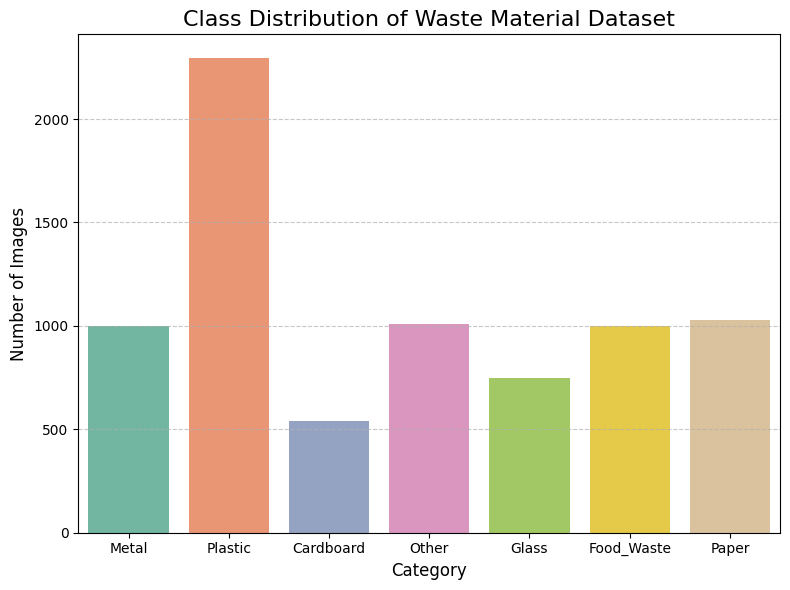

In [7]:
# Visualise Data Distribution

# We can use Counter to count the objects, lets import
from collections import Counter

# Count the number of samples in each category
catrgory_counts = Counter(y)

# Create a bar plot using the number of
plt.figure(figsize=(8, 6))
sns.barplot(x=list(catrgory_counts.keys()), y=list(catrgory_counts.values()), palette='Set2')

plt.title('Class Distribution of Waste Material Dataset', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [8]:
# Visualise Sample Images (across different labels)

def plot_sample_images(unique_labels):
    #unique_labels = np.unique(y)
    images_per_class = 5

    plt.figure(figsize=(15, len(unique_labels) * 2))

    for idx, label in enumerate(unique_labels):
        label_indices = np.where(y == label)[0][:images_per_class]
        for j, image_index in enumerate(label_indices):
            plt_idx = idx * images_per_class + j + 1
            plt.subplot(len(unique_labels), images_per_class, plt_idx)
            plt.imshow(X[image_index])
            plt.axis('off')
            if j == 0:
                plt.ylabel(label, fontsize=12)

    plt.suptitle('Sample Images Across Waste Categories', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to prevent title overlap
    plt.show()


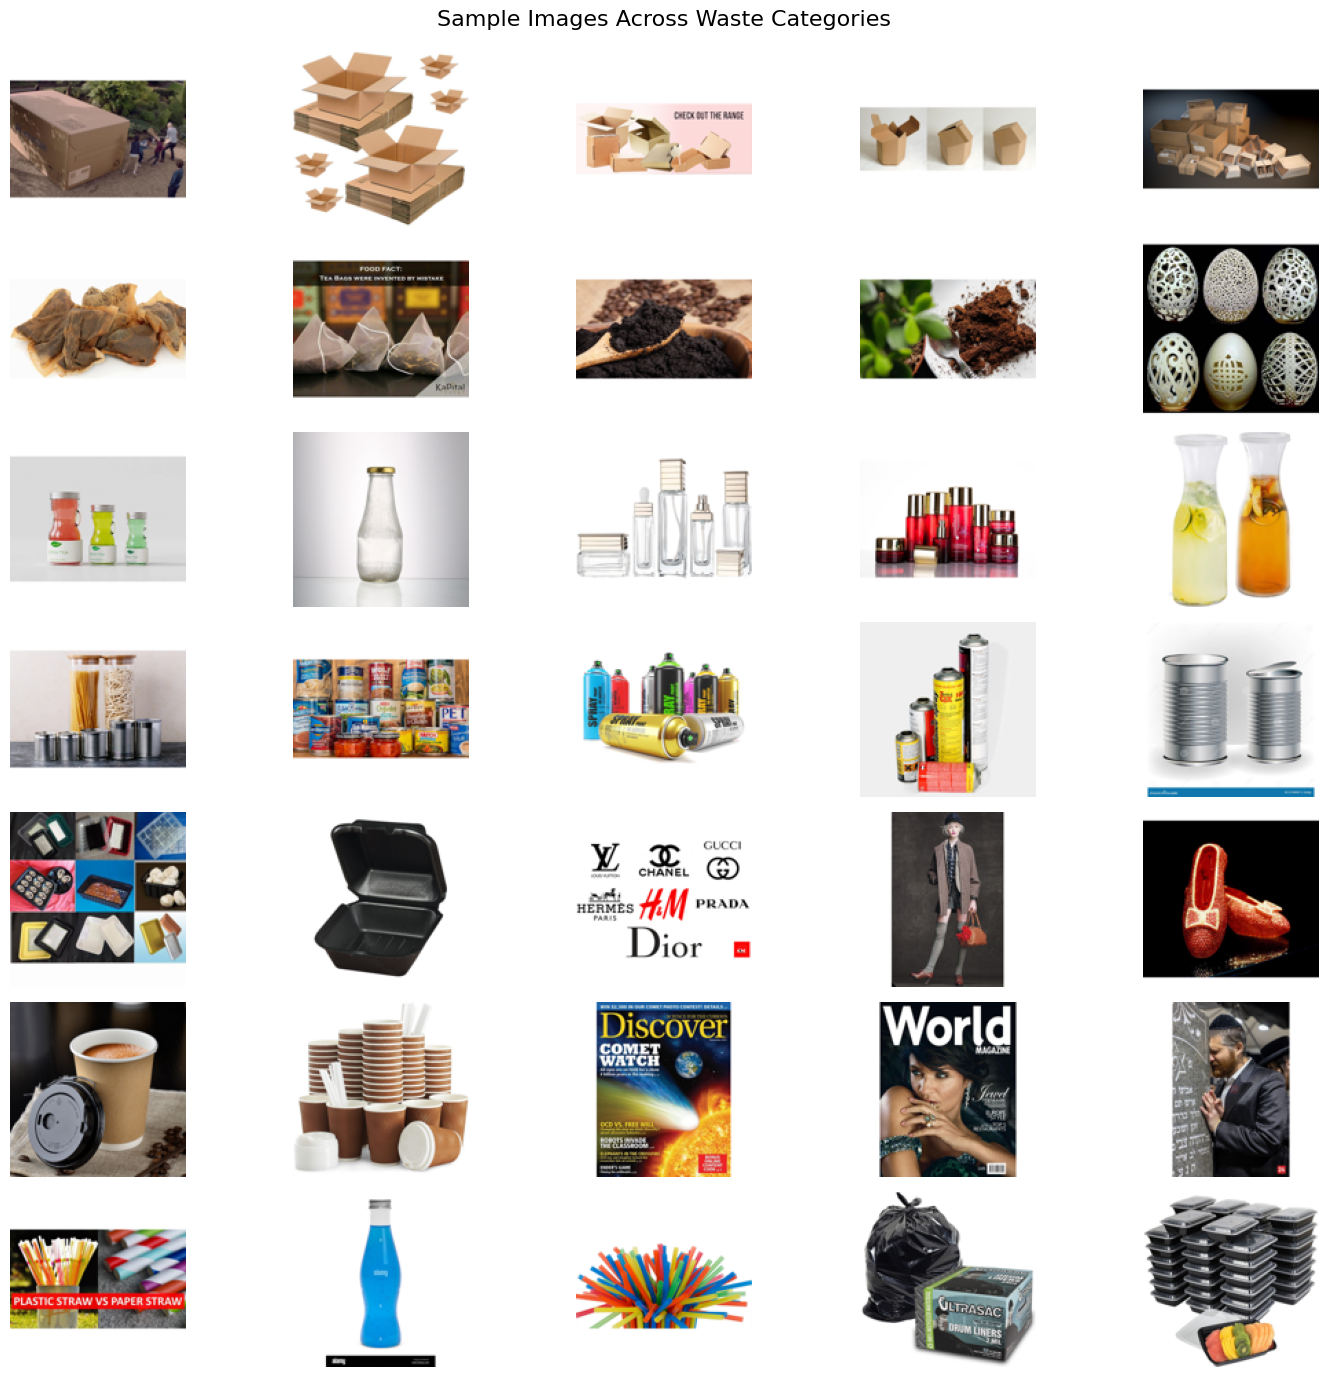

In [9]:
plot_sample_images(np.unique(y))

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [10]:
# Find the smallest and largest image dimensions from the data set
# Write a function and to accept a folder as input and print smallest and largest dimension images

def find_smallest_largest_dimensions(root_path):

    #Define and initialize variables for min and max
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    # Loop through each class folder under root_folder
    # then files under each folder to check dimension
    for folder in os.listdir(root_path):
        sub_folder_path = os.path.join(root_path, folder)
        if os.path.isdir(sub_folder_path):
            for file in os.listdir(sub_folder_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg','.gif')):
                    file_path = os.path.join(sub_folder_path, file)
                    try:
                        img = Image.open(file_path)
                        width, height = img.size

                        min_width = min(min_width, width)
                        min_height = min(min_height, height)

                        max_width = max(max_width, width)
                        max_height = max(max_height, height)
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")

    print(f"Smallest image size in given data set: {min_width}x{min_height}")
    print(f"Largest image size in given data set: {max_width}x{max_height}")


In [11]:
find_smallest_largest_dimensions(os.path.join(extracted_path, 'data'))

Smallest image size in given data set: 256x256
Largest image size in given data set: 256x256


In [12]:
# Resize the image dimensions
def resize_image_dimensions(img_size = (128, 128)):

  resized_images = [np.resize(img, img_size) for img in X]
  image_array = np.array([np.array(img) for img in resized_images]) / 255.0

  return image_array

In [13]:
#X = resize_image_dimensions(img_size = (128, 128))

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [14]:
# Encode the labels suitably
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#get the labelEncoder
label_encoder = LabelEncoder()
#create encoded label variable
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
y_categorical = to_categorical(y_encoded)

# Print to verify
print("Classes found:", label_encoder.classes_)
print("Sample encoded labels:", y_encoded[:10])
print("One-hot encoded shape:", y_categorical.shape)


Classes found: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Sample encoded labels: [3 3 3 3 3 3 3 3 3 3]
One-hot encoded shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [15]:
# Assign specified parts of the dataset to train and validation sets
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training, 20% validation sub sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42,
    shuffle=True
)

# Print summary
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Image shape: {X_train[0].shape}")
print(f"Number of classes: {y_train.shape[1]}")


Training samples: 6100
Validation samples: 1525
Image shape: (128, 128, 3)
Number of classes: 7


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [16]:
# Build and compile the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes):
    model = Sequential()

    # Conv Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    # Conv Layer 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    # Conv Layer 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [17]:
input_shape = (128, 128, 3)  # or whatever your image shape is
num_classes = 7              # number of classes

model = build_model(input_shape, num_classes)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,484,807 (32.37 MB)

 Trainable params: 8,484,359 (32.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [20]:
# Training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assume X_train, y_train, X_val, y_val are preprocessed and ready
input_shape = X_train.shape[1:]  # e.g. (128, 128, 3)
num_classes = y_categorical.shape[1]  # Number of classes after one-hot encoding

print(len(input_shape))
print(num_classes)

model = build_model(input_shape, num_classes)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

3
7
Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.2513 - loss: 5.7779 - val_accuracy: 0.2715 - val_loss: 3.4672 - learning_rate: 0.0010
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.3021 - loss: 1.8535 - val_accuracy: 0.2892 - val_loss: 2.8169 - learning_rate: 0.0010
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.3003 - loss: 1.8172 - val_accuracy: 0.3003 - val_loss: 1.8485 - learning_rate: 0.0010
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.3101 - loss: 1.7957 - val_accuracy: 0.2905 - val_loss: 1.7485 - learning_rate: 0.0010
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3091 - loss: 1.7920 - val_accuracy: 0.2931 - val_loss: 2.0989 - learning_rate: 0.0010
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2982 - loss: 1.7916 - val_accuracy: 0.3062 - val_loss: 1.7947 - learning_rate: 0.0010
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.3066 - los

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [21]:
from sklearn.model_selection import train_test_split

# Step 1: Split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical,
    test_size=0.3,
    stratify=y_encoded,
    random_state=42,
    shuffle=True
)

# Step 2: Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 30% = 15%
    stratify=np.argmax(y_temp, axis=1),
    random_state=42,
    shuffle=True
)

# Summary
print(f" Training samples: {X_train.shape[0]}")
print(f" Validation samples: {X_val.shape[0]}")
print(f" Test samples: {X_test.shape[0]}")
print(f" Image shape: {X_train[0].shape}")
print(f" Number of classes: {y_train.shape[1]}")

 Training samples: 5337
 Validation samples: 1144
 Test samples: 1144
 Image shape: (128, 128, 3)
 Number of classes: 7


In [22]:
# Evaluate on the test set; display suitable metrics
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {test_accuracy:.4f}")
print(f" Test Loss: {test_loss:.4f}")

# Predict
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test_true, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
print("\n Confusion Matrix:\n")
print(conf_matrix)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5410 - loss: 1.3313

 Test Accuracy: 0.5350
 Test Loss: 1.3246
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.38      0.86      0.52       150
           2       0.91      0.35      0.50       113
           3       0.49      0.57      0.53       150
           4       0.57      0.36      0.44       151
           5       0.51      0.30      0.38       155
           6       0.65      0.75      0.69       344

    accuracy                           0.53      1144
   macro avg       0.50      0.46      0.44      1144
weighted avg       0.54      0.53      0.51      1144


 Confusion Matrix:

[[  0  75   0   1   1   3   1]
 [  0 129   0   3   1  10   7]
 [  0  15  39   3   9   3  44]
 [  0  23   1  86   2  14  24]
 [  0  47   0   6  54   5  39]
 [  0  30   0  45   7  47  26]
 [  0  23   3

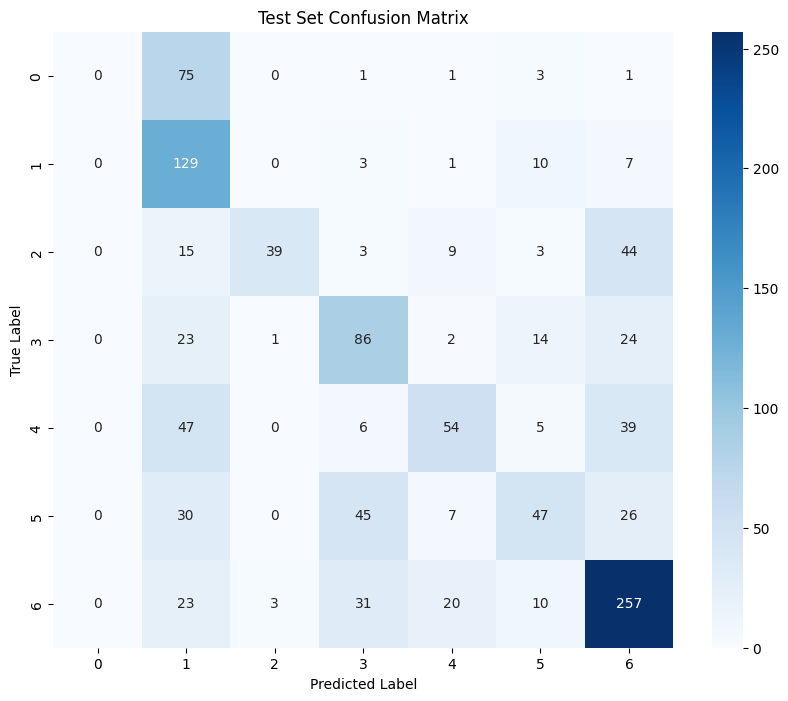

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [24]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [25]:
# Create a function to augment the images




In [26]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [27]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

### Findings from the Data
- The data set has seven folders with images for seven distinct types of waste
- In total there are 7625 images, All the images are of type .png
- Data has significant imbalance. 4 of the categories have similar number of images while othes have varied numbers. Plastic has highest 2295 images. This can result in biased training.
- Dimension of the images are almost similar.

### Model Training approach and Results
- The data analysis was conducted with a training and valdation split of 80:20

##### ->Overall Analysis
- The training accuracy was ~53% which is not so good and there is room to improve.
- Test loss of ~1.32 46 needs improvement, lower test loss means better performance.
- The weighted F1-score (0.51) suggests performance is skewed toward more frequent classes.

##### -> Analysis of Classification Report
For class reference [ 0 = metal, 1 = plastic, 2 = cardboard, 3 = other, 4 = glass, 5 = food_waste, 6 = paper]

- Class 6 (paper) performs the best overall: high precision (0.69) and decent recall (0.75), leading to the highest F1-score (0.69).
- Class 1 (plastic) has highest recall (0.86), but low precision (0.38), meaning it often misclassifies other classes as 1.
- Classes 4 and 5 (glass and food_waste)Moderate precision and low recall, indicating misclassification issues.
- Class 2 (Card board) has high precision but low recall, indicating missed detections.

##### -> Analysis of Confusion Matrix
- Class 0 - Mostly predicted as class 1, showing poor differentiation.
- Class 1 - Mostly predicted correctly with very few wrong ones.
- Class 2 - Moderate and major wrongly predicted as class 6.
- Class 3 - 86% predicted correctly but most of wrong predictions creeping into class 1 and 6.
- Class 4 - Moderate 54%, rest majorly going to 1 and 6.
- Class 5 - Majorly wrong predcitions going to 1,3 and 6.
- Class 6 - Highest correct prediction of 257 but still needs improvement.

### Insights from analysis
- No correct prediction in class 0 could be due to fewer examples, class imbalance.
- Higher prediction in class 1 as per confusion matrix could be due to high recall and low precision.
- Heavy confusion in classes 3 -> 6, Class 2 ↔-> 6, Class 5 -> 3
- Model Complexity: The current model may be underfitting or overfitting

### Recommendations
- To handle class imbalance, Use class weights or oversample minority classes (e.g. Class 0).Consider SMOTE or RandomOverSampler.
- Enhance feature extraction by using pretrained models like ResNet, MobileNet.
- Investigate misclassified examples to understand if certain classes are visually similar or ambiguous.


  
